##### **Imports**

In [240]:
# Maths and data manipulation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# For the neural network (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

# Implementing neural network model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score

##### **Parameters**

In [241]:
# Random seed
random = 101
np.random.seed(random)
torch.manual_seed(random)


# Neural network parameters
hidden_layers = 1 # Number of hidden layers

# Training parameters
number_folds = 5 # Number of folds for cross-validation
learning_rate = 0.01
weight_decay = 0.001 # This corresponds to the L2 regularisation in PyTorch
epochs = 1000 # Number of epochs for training
pca_on = True


##### **Pre-processing**

In [242]:
df_all = pd.read_excel('/Users/isacfiorotti/repo/msc/COMP4139/CW2/TrainDataset2023.xls')

# Drop the first column from the DataFrame
df_all.drop(df_all.columns[:1], axis=1, inplace=True)

# Remove rows which have pCR (outcome) as 999
df_all = df_all[df_all['pCR (outcome)'] != 999]

In [243]:
#for column 12 and onwards
cols = df_all.columns[12:]
#clip outliers in the 99th percentile
df_all[cols] = df_all[cols].clip(upper=df_all[cols].quantile(0.99), axis=1)

#min max scaling for mri values only
cols = df_all.columns[12:]
df_all[cols] = (df_all[cols] - df_all[cols].min()) / (df_all[cols].max() - df_all[cols].min())

# normalise these values using the standard scaler
cols = df_all.columns[12:]
scaler = StandardScaler()
df_all[cols] = scaler.fit_transform(df_all[cols])


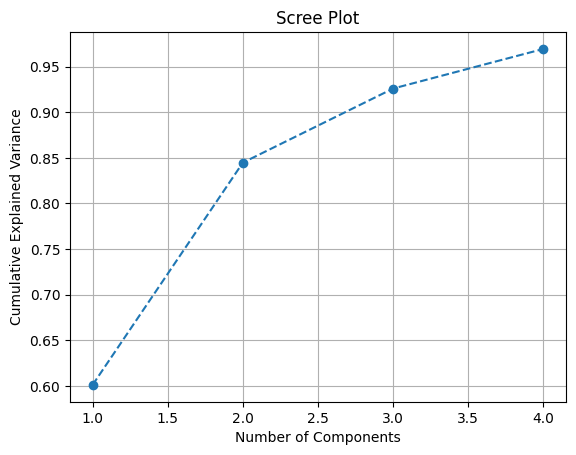

In [244]:
# Split the dataset into training and testing data
X = df_all.drop('pCR (outcome)', axis=1)
y = df_all['pCR (outcome)']

if pca_on:
    # PCA
    pca = PCA(n_components=0.95)
    pca.fit_transform(X)
    variance = pca.explained_variance_ratio_ 
    cumulative_variance = variance.cumsum()

    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Scree Plot')
    plt.grid()
    plt.show()

In [245]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [246]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random)

# Convert the data into tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train.values)
y_test_tensor = torch.LongTensor(y_test.values)

# Get the number of input features
input_features = X_train.shape[1]

##### **Model**

In [247]:
class ANN(nn.Module):
    def __init__(self, input_features, hidden1=hidden_layers, out_features=2):
        super().__init__()
        self.f_connected1 = nn.Linear(input_features, hidden1)
        self.out = nn.Linear(hidden1, out_features)

    def forward(self, x):
        x = self.f_connected1(x)
        x = F.sigmoid(x)
        x = self.out(x)
        return x


##### **Training**

Recall score for fold 1 on unseen data: 0.0
F1 score for fold 1 on unseen data: 0.0
Recall score for fold 2 on unseen data: 0.0
F1 score for fold 2 on unseen data: 0.0
Recall score for fold 3 on unseen data: 0.0
F1 score for fold 3 on unseen data: 0.0
Recall score for fold 4 on unseen data: 0.15789473684210525
F1 score for fold 4 on unseen data: 0.23076923076923078
Recall score for fold 5 on unseen data: 0.0
F1 score for fold 5 on unseen data: 0.0


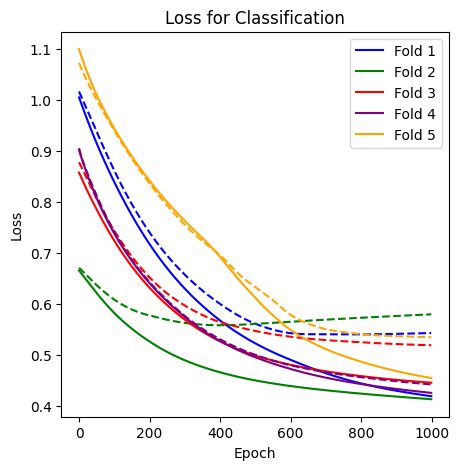

In [248]:
model = ANN(input_features)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

kf = KFold(n_splits=number_folds, shuffle=True, random_state=random)

# Create a new figure
plt.figure(figsize=(5, 5))
colors = ['blue', 'green', 'red', 'purple', 'orange']
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss for Classification')


for fold, (train_indicies, val_indicies) in enumerate(kf.split(X_train)):

    # reset the model
    model = ANN(input_features)

    X_fold_train = X_train_tensor[train_indicies]
    y_fold_train = y_train_tensor[train_indicies]
    X_fold_val = X_train_tensor[val_indicies]
    y_fold_val = y_train_tensor[val_indicies]    

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay)

    losses = []
    val_losses = []

    for i in range(epochs):
        y_pred = model.forward(X_fold_train)
        loss = criterion(y_pred, y_fold_train)

        # Zero the gradients
        optimizer.zero_grad()

        # Backpropagation
        loss.backward()

        # Update the weights
        optimizer.step()

        # Append the loss
        losses.append(loss.item())

        # Calculate the validation loss
        with torch.no_grad():
            y_val_pred = model.forward(X_fold_val)
            val_loss = criterion(y_val_pred, y_fold_val)
            val_losses.append(val_loss.item())

    # recall score for each fold on unseen data x_test and y_test
    predictions = []
    with torch.no_grad():
        for data in X_test_tensor:
            y_pred = model(data)
            predictions.append(y_pred.argmax().item())
    
    recall = recall_score(y_test_tensor, predictions)
    print(f"Recall score for fold {fold+1} on unseen data: {recall}")

    # f1 score for each fold on unseen data x_test and y_test
    f1 = f1_score(y_test_tensor, predictions)
    print(f"F1 score for fold {fold+1} on unseen data: {f1}")

    # Plot the loss in small figure next to each other
    plt.plot(range(epochs), losses, colors[fold], label=f"Fold {fold+1}")

    # Plot the validation set for each fold in the same graph and same colour but using dotted lines
    plt.plot(range(epochs), val_losses, colors[fold], linestyle='dashed')


# Show fold legend
plt.legend()




tensor([0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 1])
Balanced accuracy score for unseen data: 0.6021929824561403
Recall score for unseen data: 0.42105263157894735
F1 score for unseen data: 0.4


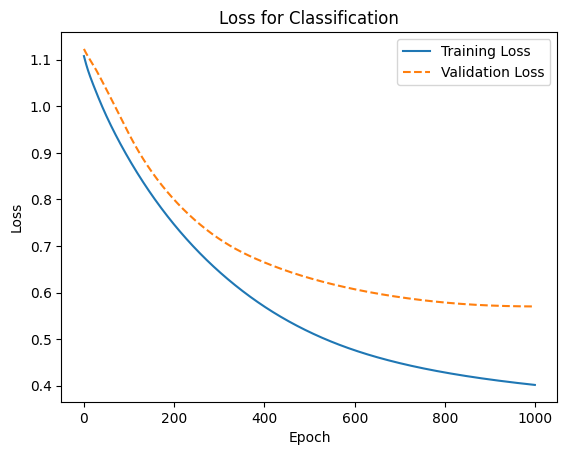

In [249]:
model1 =  ANN(input_features)

# Split trainining data into training and validation
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(X_train_tensor, y_train_tensor, test_size=0.2, random_state=random)

losses = []
val_losses = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), weight_decay=weight_decay)

for i in range(epochs):
    y_pred = model1.forward(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)

    # Zero the gradients
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Update the weights
    optimizer.step()

    # Append the loss
    losses.append(loss.item())

    # Calculate the validation loss
    with torch.no_grad():
        y_val_pred = model1.forward(X_val_tensor)
        val_loss = criterion(y_val_pred, y_val_tensor)
        val_losses.append(val_loss.item())

# Plot the loss
plt.plot(range(epochs), losses, label="Training Loss")

# Plot the validation set
plt.plot(range(epochs), val_losses, label="Validation Loss", linestyle='dashed')

# Show legend
plt.legend()

plt.title('Loss for Classification')
plt.xlabel("Epoch")
plt.ylabel("Loss")



model.eval()
with torch.no_grad():
    y_pred = model1(X_test_tensor)
    _, predicted = torch.max(y_pred, 1)
recall = recall_score(y_test_tensor, predicted)
f1 = f1_score(y_test_tensor, predicted)
balanced_accuracy_score = balanced_accuracy_score(y_test_tensor, predicted)
print(y_test_tensor)
print(predicted)
print(f"Balanced accuracy score for unseen data: {balanced_accuracy_score}")

print(f"Recall score for unseen data: {recall}")
print(f"F1 score for unseen data: {f1}")